# Imports

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root, minimize, root_scalar, minimize_scalar
from scipy.linalg import solve_discrete_lyapunov, block_diag
from scipy.signal import correlate, hilbert, spectrogram, periodogram, welch
from sklearn.base import BaseEstimator
from scipy.special import factorial
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("default", category=RuntimeWarning)


In [2]:
from helpers import *

In [60]:
order = 3
dN_k = 1
mu = -3.5
beta = np.array([1,0,1,0]).reshape(1,-1)
xp_k = np.random.random(size=(4,1))
Pp_k = np.random.random(size=(4,4))
xp_k, Pp_k

(array([[0.50422843],
        [0.4890948 ],
        [0.45519576],
        [0.45614705]]),
 array([[0.0410645 , 0.35902294, 0.19977536, 0.86683911],
        [0.4260618 , 0.62195357, 0.52827705, 0.41158793],
        [0.43011851, 0.57890305, 0.40988768, 0.63674777],
        [0.62045243, 0.31752623, 0.11477209, 0.96152391]]))

In [111]:
def trial(xp_k, Pp_k, dN_k, mu, beta, order = 3):
    exponents = []
    signs = []
    for n in range(0, order+1):
        exp_term = (dN_k+n)*(mu + np.dot(beta, xp_k) + (dN_k+n)*np.linalg.multi_dot([beta, Pp_k, beta.T])/2) - gammaln(n + 1)
        exponents.append(exp_term)
        signs.append((-1)**n)
    logval, logsign = logsumexp(np.array(exponents).squeeze(), b = np.array(signs), return_sign=True)
    log_k = np.abs(logval)*logsign
    return log_k

#OOOF. What tf is going on here

# exponents = np.array(exponents).squeeze()
# max_exp = exponents.max()
# summ = sum(np.array(signs)*np.exp(exponents - max_exp))
# out_sign = np.sign(summ)
# log_k = max_exp + np.log(np.abs(summ))
# log_k


In [104]:
def _k_likelihood(xp_k, Pp_k, dN_k, mu, beta, order = 3):
    L = 0
    for n in range(0, order+1):
        # exp_term = (dN_k + n)*(mu + xp_k[0] + (dN_k + n)*Pp_k[0,0]/2)
        exp_term = (dN_k+n)*(mu + np.dot(beta, xp_k) + (dN_k+n)*np.linalg.multi_dot([beta, Pp_k, beta.T])/2) - gammaln(n + 1)
        L += ((-1)**n)*np.exp(exp_term)
        # L += ((-1)**n/factorial(n))*np.exp(exp_term)
    logL_k = np.log(L)
    return logL_k.squeeze()

In [105]:
np.random.choice([0,1])

np.int64(0)

In [106]:
for _ in range(10):
    order = 3
    dN_k = np.random.choice([0,1])
    mu = -3.5
    beta = np.array([1,0,1,0]).reshape(1,-1)
    xp_k = np.random.random(size=(4,1))
    Pp_k = np.random.random(size=(4,4))
    xp_k, Pp_k
    print(np.allclose(trial(xp_k, Pp_k, dN_k, mu, beta), _k_likelihood(xp_k, Pp_k, dN_k, mu, beta)))

-0.8120690188708997 1.0
True
1.1169255056820475 -1.0
False
0.10709642040135825 -1.0
False
-1.168497614292502 1.0
True
-0.11602635678151185 -1.0
False
2.722899382196784 -1.0
False
-0.34380715255665695 1.0
True
-0.10379862199441195 1.0
True
3.3363995686602768 -1.0
False
6.813439338515943 -1.0
False


In [107]:
trial(xp_k, Pp_k, dN_k, mu, beta), _k_likelihood(xp_k, Pp_k, dN_k, mu, beta)

6.813439338515943 -1.0


(np.float64(-6.813439338515943), array(nan))

In [108]:
_k_likelihood(xp_k, Pp_k, dN_k, mu, beta)

array(nan)

In [74]:
np.isclose(logsumexp(exponents, b = signs, return_sign=True)[0] , log_k)

np.True_

In [75]:
logsumexp(np.array(exponents).squeeze(), b = signs, return_sign=True)

(np.float64(-2.5711389587816633), np.float64(1.0))

In [41]:
from scipy.special import loggamma, gammaln, logsumexp

In [17]:
n = 3
np.log(1/factorial(n)) , -loggamma(n+1), -gammaln(n+1)

(np.float64(-1.791759469228055),
 np.float64(-1.791759469228055),
 np.float64(-1.791759469228055))

In [5]:
np.log(np.e)

NameError: name 'e' is not defined

# Trials

In [3]:
def rotf(f, Fs):
    '''Rotation matrix for a given oscillation frequency.
    '''
    if np.isscalar(f):
        w = 2*np.pi*f/Fs
        return np.array([[np.cos(w), -np.sin(w)], [np.sin(w), np.cos(w)]], dtype=np.float64)
    elif np.asarray(f).squeeze().ndim == 1:
        blocks = [rotf(freq, Fs) for freq in np.asarray(f).squeeze()]
        # print(blocks, np.array(blocks).shape)
        return block_diag(*blocks)
    else:
        raise AssertionError(f"Input `f` must be a scalar or a 1D array-like, but got shape {np.asarray(f).shape}")
    

In [4]:
rng = np.random.default_rng()

In [11]:
D = 2
Fs = 1000
N = 5000

alphas  = [(0.9999 - 0.993)*rng.random() + 0.993 for i in range(D)]
osc_F = [2, 8]
sigmas = [0.0001, 0.00015]
print('alphas: ',alphas)
print('sigmas: ',sigmas)
print('osc Freqs: ',osc_F)
Qs = [sigma*np.eye(2) for sigma in sigmas]

alphas:  [0.9972909628378613, 0.9977299699346035]
sigmas:  [0.0001, 0.00015]
osc Freqs:  [2, 8]


In [12]:
Q = block_diag(*Qs)
R_full = rotf(osc_F, 1000)
phi = np.repeat(alphas, 2)*R_full

In [13]:
U = rng.normal(0, scale=np.sqrt(np.repeat(sigmas, 2)).reshape(-1,1), size=(2*D,N))

In [14]:
X = np.zeros_like(U)

In [15]:
X[:, 0] = U[:, 0]
for k in range(1,N):
    X[:, k] = np.dot(phi, X[:, k-1]) + U[:, k-1]


In [21]:
mu = 4*rng.random() - 6
print('mu : ', mu)
mu = -3.5

mu :  -4.1345085593003095


In [22]:
e_hat = np.tile([1,0], D)
e_hat

array([1, 0, 1, 0])

In [23]:
beta = np.repeat([1, 1], 2)
beta*e_hat, (e_hat*beta).shape 

(array([1, 0, 1, 0]), (4,))

In [24]:
np.dot(beta*e_hat, X[:, 0:1])

array([0.0172164])

In [25]:
beta = (e_hat*beta).reshape(1, -1)
beta.shape

(1, 4)

In [26]:
obs = np.exp(mu + np.dot(beta, X))

In [27]:
y = np.zeros_like(obs)
for i, yi in enumerate(obs[0]):
    if yi > rng.random():
        y[:, i] = 1

In [28]:
np.mean(y)*Fs

np.float64(31.0)

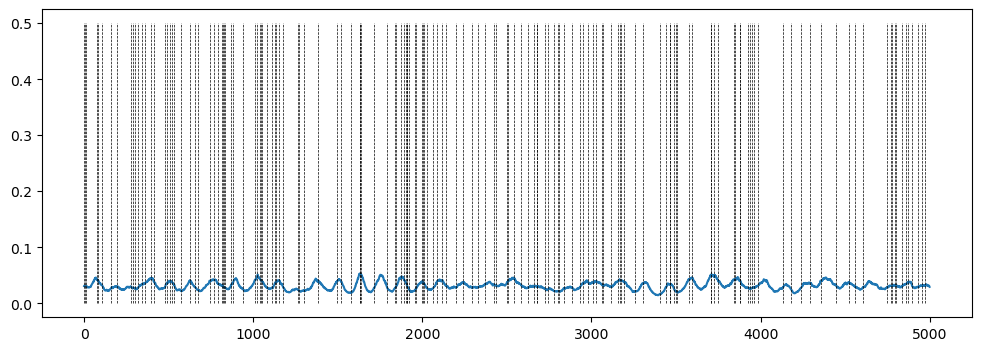

In [29]:
plt.figure(figsize=(12, 4))
plt.plot(obs[0])
plt.vlines(np.where(y[0]), ymin = 0, ymax= 0.5 , ls='--', color='k', lw = 0.5)

In [30]:
osc_F

[2, 8]

In [31]:
y.shape

(1, 5000)

In [32]:
beta.shape

(1, 4)

In [33]:
x0 = X[:, 0:1]
x0.shape

(4, 1)

In [34]:
mu, alphas, osc_F, sigmas, beta

(-3.5,
 [0.9972909628378613, 0.9977299699346035],
 [2, 8],
 [0.0001, 0.00015],
 array([[1, 0, 1, 0]]))

In [35]:
mu0 = -3
alpha0 = [0.99, 0.99]
freq0 = [1,7]
sigma0 = [0.001, 0.001]

In [36]:
from EM_multi import EMEstimator

In [37]:
model = EMEstimator(x0, mu0, alpha0, freq0, sigma0, beta, Fs, D)

In [38]:
param_history, E_steps, params_hat, error_log, inits = model._em_algorithm(x0, y, mu0, alpha0, freq0, sigma0, beta, max_iter = 20, log_file = 'multi_params.csv')

10 20 

In [47]:
len(E_steps['x_p']), beta

(20, array([[1, 0, 1, 0]]))

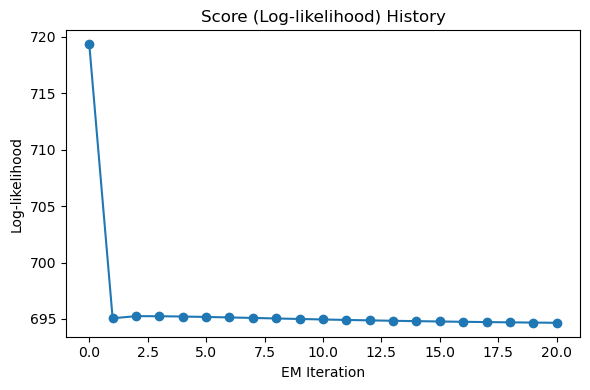

In [59]:
score = []
iterations = list(range(0, len(E_steps['x_p'])+1))

for itr in iterations:
    mu_itr = param_history.loc[itr, 'mu_']
    
    xp_itr = E_steps['x_p'][itr-1]
    Pp_itr = E_steps['P_p'][itr-1]

    # score_val = model._log_likelihood(xp_itr, Pp_itr, y, mu_itr, beta)
    logL = 0
    for k in range(N):
        logL += model._k_likelihood(xp_itr[:, k:k+1], Pp_itr[..., k], y[:, k], mu_itr, beta)
    score.append(logL)

plt.figure(figsize=(6, 4))
plt.plot(iterations, score, marker='o')
plt.xlabel("EM Iteration")
plt.ylabel("Log-likelihood")
plt.title("Score (Log-likelihood) History")
plt.tight_layout()
plt.show()

In [39]:
try:
    model.plot_score_history(y, step=1)
except:
    model.plot_score_history(y[0], step=1)

NotFittedError: This EMEstimator instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [38]:
np.array(E_steps['B']).shape

(50, 6, 6)

In [ ]:
plt.plot(E_steps['x_p'][10][0], axis1=1, axis2=2)

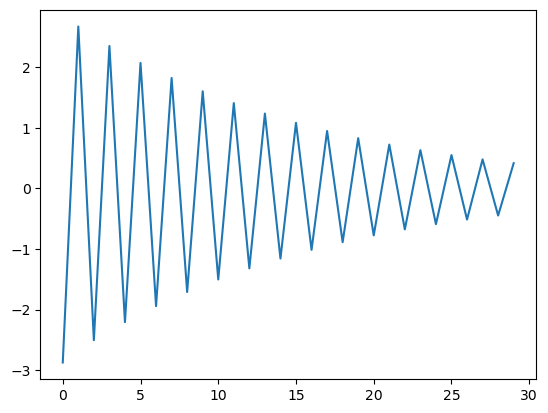

In [67]:
# plt.plot(np.trace(np.array(E_steps['B']), axis1=1, axis2=2))
# plt.plot(model._rt(np.array(E_steps['B'])))
plt.plot(np.array(E_steps['B'])[:, 1, 0] - np.array(E_steps['B'])[:, 0, 1])
# plt.plot(np.array(E_steps['B'])[:, 1, 0])
# plt.plot(np.array(E_steps['B'])[:, 1, 1])
# plt.plot(X[0])

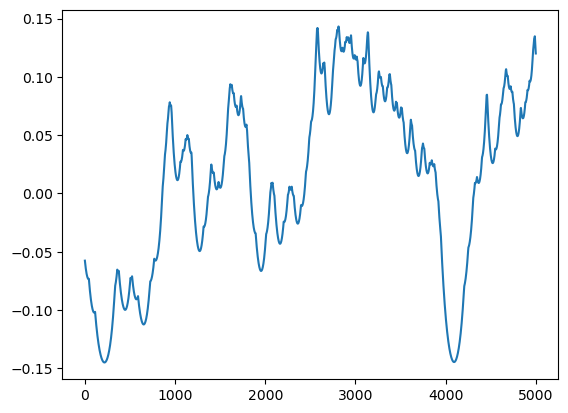

In [76]:
plt.plot(np.array(E_steps['x_b'][6])[0])

In [32]:
param_history.head()

,mu_,alpha1_,alpha2_,alpha3_,freq1_,freq2_,freq3_,sigma1_,sigma2_,sigma3_
0,-3,0.99,0.99,0.99,1,3,5,0.001,0.001,0.001
1,-3.50612,0.990989,0.990054,0.98975,-0.826808,-2.734789,-4.656701,0.001,0.001002,0.001005
2,-3.604148,0.990998,0.989998,0.989665,0.767916,2.582553,4.398463,0.001,0.001003,0.001009
3,-3.623926,0.99105,0.989991,0.98964,-0.712983,-2.438811,-4.152794,0.001,0.001004,0.001012
4,-3.628537,0.991114,0.989996,0.98963,0.661723,2.303142,3.921246,0.001,0.001005,0.001016


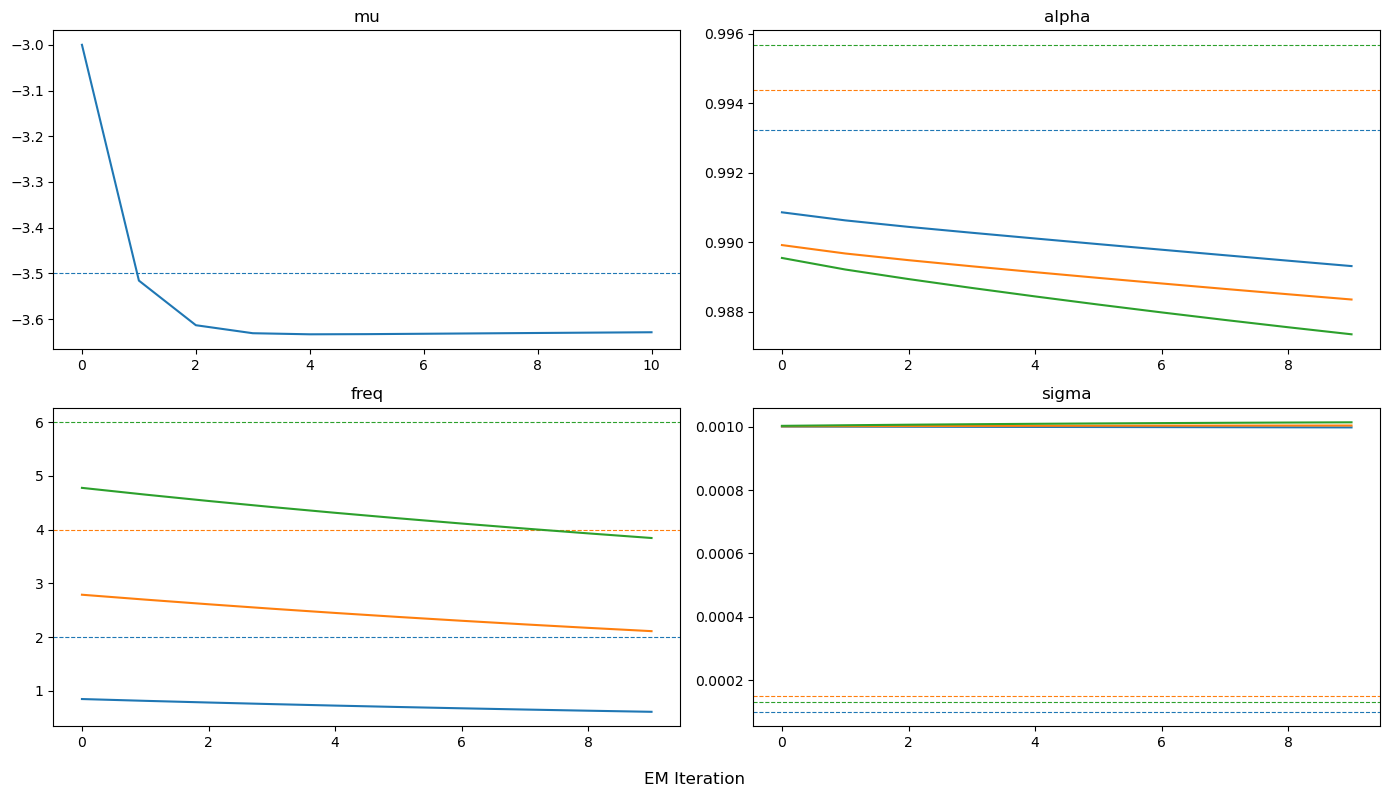

In [28]:
param_names = ['mu', 'alpha', 'freq', 'sigma']
true_params = [mu, alphas, osc_F, sigmas]

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

for ix, (name, ax, true_val) in enumerate(zip(param_names, axs.ravel(), true_params)):
    n_osc = np.asarray(true_val).size
    if n_osc == 1:
        ax.plot(param_history.filter(regex=name), label='Estimated', color='C0')
        ax.axhline(true_val, color='C0', linestyle='--', label='True', lw=0.8)
    else:
        for phx, ci, true_n in zip(param_history.filter(regex=name).loc[1:].to_numpy().T, [f'C{i}' for i in range(n_osc)], true_val):
            ax.plot(phx, label='Estimated', color=ci)
            ax.axhline(true_n, color=ci, linestyle='--', label='True', lw=0.8)

    ax.set_title(name)
    # ax.legend()

fig.supxlabel("EM Iteration")
fig.tight_layout()
plt.show()

In [64]:
def klikelihood(xp_k, Pp_k, dN_k, mu, beta, order = 3):
    L = 0
    for n in range(0, order+1):
        exp_term = (dN_k + n)*(mu + np.dot(beta, xp_k) + (dN_k + n)*np.linalg.multi_dot([beta, Pp_k, beta.T])/2)
        L += ((-1)**n/factorial(n))*np.exp(exp_term)
    logL_k = np.log(L)
    return logL_k
        
def log_likelihood(x_p, P_p, dN, mu, beta, order = 3):
    K = dN.shape[-1]
    logL = 0
    for k in range(K):
        logL += klikelihood(x_p[:, k], P_p[..., k], dN[k], mu, beta, order = order)
    return logL

In [65]:
param_history.head()

,mu_,alpha1_,alpha2_,alpha3_,freq1_,freq2_,freq3_,sigma1_,sigma2_,sigma3_
0,-3,0.99,0.99,0.99,1,3,5,0.001,0.001,0.001
1,-3.504187,0.990915,0.989941,0.989656,-0.833349,-2.76798,-4.704909,0.001,0.001001,0.001004
2,-3.60068,0.990866,0.989738,0.989454,0.78127,2.660735,4.507118,0.001,0.001002,0.001007
3,-3.618993,0.990871,0.989585,0.989303,-0.731914,-2.559884,-4.323382,0.001,0.001003,0.00101
4,-3.622594,0.990892,0.989447,0.989164,0.685693,2.464858,4.152273,0.001,0.001003,0.001012


In [66]:
klikelihood(E_steps['x_p'][0][:, 2], E_steps['P_p'][0][..., 2], y[0], mu, beta)

array([[-0.03216501, -0.03216501, -0.03216501, ..., -0.03216501,
        -0.03216501, -0.03216501]], shape=(1, 5000))

In [52]:
score = []
iterations = list(range(0, len(E_steps['x_p'])+1))

for itr in iterations:
    mu_itr = param_history.loc[itr, 'mu_']
    # alpha_itr = param_history.loc[itr, 'alpha_']
    # F_itr = param_history.loc[itr, 'F_']
    # omega_itr = param_history.loc[itr, 'omega_']
    # sigma_itr = param_history.loc[itr, 'sigma_']
    
    xp_itr = E_steps['x_p'][itr-1]
    Pp_itr = E_steps['P_p'][itr-1]

    score_val = log_likelihood(y, mu_itr, xp_itr, Pp_itr, beta)
    score.append(score_val)

plt.figure(figsize=(6, 4))
plt.plot(iterations, score, marker='o')
plt.xlabel("EM Iteration")
plt.ylabel("Log-likelihood")
plt.title("Score (Log-likelihood) History")
plt.tight_layout()
plt.show()


TypeError: 'int' object is not subscriptable

In [41]:
model

EMEstimator(Fs=1000, alpha0=[0.99, 0.99, 0.99], am=np.float64(57.2),
            beta=array([[1, 0, 1, 0, 1, 0]]), bm=2000, freq0=[1, 3, 5], mu0=-3,
            n_oscillations=3, sigma0=[0.001, 0.001, 0.001],
            x0=array([[ 0.00615151],
       [ 0.00864995],
       [-0.0061608 ],
       [ 0.00960439],
       [-0.00139633],
       [-0.00123097]]))

In [41]:
alpha

NameError: name 'alpha' is not defined

<Axes: >

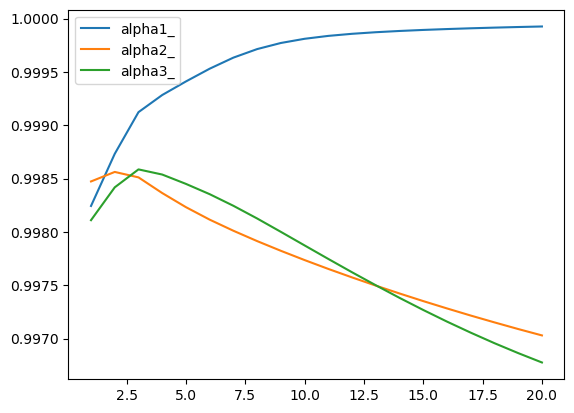

In [40]:
param_history.filter(regex='alp').loc[1:].plot()

In [1]:
for i in np.array([2, 4]):
    print(i, type(i))


KeyboardInterrupt



In [ ]:
-np.array(osc_F)

In [ ]:
rotf(np.array([2,4]), 1000)

In [ ]:
params_hat

In [ ]:
phi.shape

In [ ]:
error_log

In [ ]:
beta.shape

In [ ]:
np.einsum('ij,jkl,ki->il', beta, P, beta.T).shape


In [ ]:
res = []
for i in range(1000):
    res.append(np.linalg.multi_dot([beta, P[..., i], beta.T]))
(np.array(res).reshape(1,1000) == np.einsum('ij,jkl,ki->il', beta, P, beta.T)).all()

In [ ]:
for i in range(1000):
    P = rng.random(size=(6,6, 1000))
    BGG  = rng.random(size=(6,6, 1000))
    checcccc = (np.einsum('ijk,kjl->kil', P[:, :, 1:], BGG[:, :, :-1].T)== np.matmul(np.transpose(P[:, :, 1:], axes=(2,0,1)), np.transpose(BGG[:, :, :-1], axes=[2,1,0]))).all()
    np.testing.assert_allclose(np.einsum('ijk,kjl->ilk', P[:, :, 1:], BGG[:, :, :-1].T).sum(axis=-1), np.matmul(np.transpose(P[:, :, 1:], axes=(2,0,1)), np.transpose(BGG[:, :, :-1], axes=[2,1,0])).sum(axis=0))
    if not checcccc:
        print(i)

In [ ]:
P = rng.random(size=(6,6, 1000))
BGG  = rng.random(size=(6,6, 1000))
XB = rng.random(size=(6, 1000))
mu_sum = np.dot(beta, XB) + np.einsum('ij,jkl,ki->il', beta, P, beta.T)

In [ ]:
X.shape

In [ ]:
jac = -np.dot(phi, X[:, 3] - X[:, 2])
jac += (y[:, 2] - np.exp(mu + np.dot(beta,X[:, 3])))*beta.T

In [ ]:
x = x0.copy().reshape(-1, 1)
dot2 = (-1/2)*np.linalg.multi_dot([(x - X[:, 2:3]).T, phi, x - X[:, 2:3]])
L = y[:, 3]*(mu + np.dot(beta,x)) - np.exp(mu + np.dot(beta,x)) + dot2
L.item()

In [ ]:
x = x.reshape(-1, 1)
jac = -np.dot(phi, x - X[:, 2:3])
jac += (y[:, 3] - np.exp(mu + np.dot(beta,x)))*beta.T
jac, jac.item().shape

In [ ]:
hess = -Pinv.copy() - np.exp(mu + np.dot(beta,x))*np.dot(beta.T, beta)

In [ ]:
dot2 = (-1/2)*np.linalg.multi_dot([(X[:, 2] - X[:, 3]).T, phi, X[:, 2] - X[:, 3]])
L = y[:, 1]*(mu + np.dot(beta,X[:, 2])) - np.exp(mu + np.dot(beta,X[:, 2])) + dot2

In [ ]:
model._rotf(model.freq0)

In [ ]:
del EMEstimator

In [ ]:
np.round(np.exp(mu + np.dot(beta,X[:, 1:2]))*np.dot(beta.T, beta), 4)

In [ ]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import decimate

y_smooth = gaussian_filter1d(y.astype(float), sigma=3)
y_down = decimate(y_smooth, q=10)

In [ ]:
f, Pxx = welch(y_down, Fs/10, scaling='density', detrend=False)
plt.figure()
plt.plot(f, Pxx)
# plt.ylim([1e-4, 1e1])
plt.xlim([0, 30])
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

In [ ]:
from scipy.signal import find_peaks

peaks, prop = find_peaks(Pxx, height=np.max(Pxx)*0.001)
freq_estimates = f[peaks]


In [ ]:
freq_estimates = [f[a] for _, a in sorted(zip(prop['peak_heights'], peaks), reverse=True)][:D]

In [ ]:
freq_estimates

In [ ]:
R_full

In [ ]:
beta.reshape(1, -1).shape

In [ ]:
np.dot(beta.reshape(1, -1).T, beta.reshape(1, -1))

In [ ]:
beta = beta.reshape(1,-1)
jac = -np.dot(phi, X[:, 1:2] - X[:, 2:3])
jac += (1 - np.exp(mu + np.dot(beta,X[:, 1:2])))*beta.T
jac


In [ ]:
dot2 = (-1/2)*np.linalg.multi_dot([(X[:, 1:2] - X[:, 2:3]).T, phi, (X[:, 1:2] - X[:, 2:3])])
L = 1*(mu + np.dot(beta,X[:, 1:2])) - np.exp(mu + np.dot(beta,X[:, 1:2])) + dot2
L, L.shape

In [ ]:
hess = -phi.copy()
hess -= np.exp(mu + np.dot(beta,X[:, 1:2]))*np.dot(beta.T, beta)
hess.shape

In [ ]:
from EM_sk import EMEstimator

In [ ]:
cls = EMEstimator(x0, mu, alphas, sigmas, osc_F, beta=1, Fs=Fs, gamma=1e3, method='trust-krylov', max_iter=20)